In [1]:
# ! pip remove fbprophet
# ! pip install pystan==2.19.1.1
# ! pip install fbprophet

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False


In [3]:
df = pd.read_csv('ts_data.csv')

In [4]:
df['timeStamp']=pd.to_datetime(df['timeStamp'])
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [5]:
fig = px.line(df, x='timeStamp', y='demand', hover_data=['temp'], title='NYC Energy Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [6]:
ny_df=df.set_index('timeStamp')
ny_df.head()

,demand,precip,temp
timeStamp,,,
2012-01-01 00:00:00,4937.5,0.0,46.13
2012-01-01 01:00:00,4752.1,0.0,45.89
2012-01-01 02:00:00,4542.6,0.0,45.04
2012-01-01 03:00:00,4357.7,0.0,45.03
2012-01-01 04:00:00,4275.5,0.0,42.61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff173836cd0>,
      dtype=object)

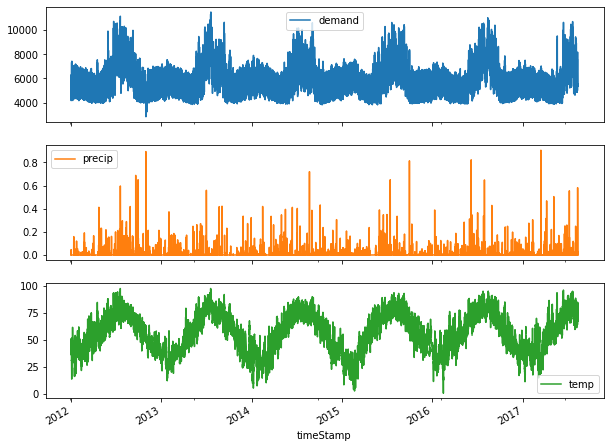

In [7]:
ny_df.plot(subplots=True)

In [8]:
ny_df.resample('D').mean()

,demand,precip,temp
timeStamp,,,
2012-01-01,4954.833333,0.002487,46.510000
2012-01-02,5302.954167,0.000000,40.496667
2012-01-03,6095.512500,0.000000,26.672500
2012-01-04,6336.266667,0.000000,20.585000
2012-01-05,6130.245833,0.000000,33.577500
...,...,...,...
2017-08-08,6471.626042,0.000000,71.039167
2017-08-09,6811.112167,0.047529,73.852500
2017-08-10,5582.297000,0.002033,75.217500


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1733f1790>,
      dtype=object)

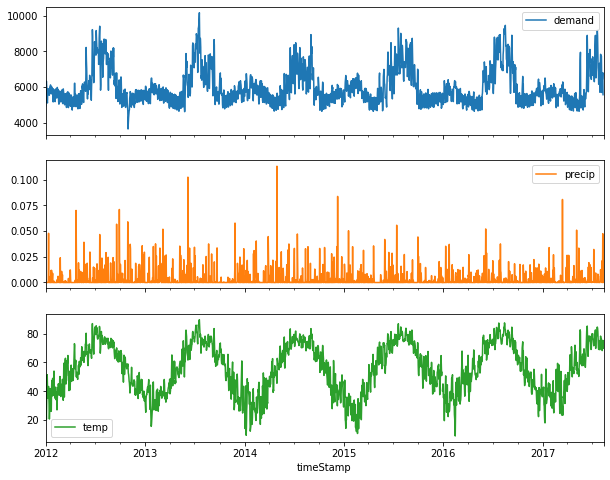

In [9]:
ny_df.resample('D').mean().plot(subplots=True)

In [10]:
ny_df_daily = ny_df.resample('D').mean()
ny_df_daily.head()

,demand,precip,temp
timeStamp,,,
2012-01-01,4954.833333,0.002487,46.510000
2012-01-02,5302.954167,0.000000,40.496667
2012-01-03,6095.512500,0.000000,26.672500
2012-01-04,6336.266667,0.000000,20.585000
2012-01-05,6130.245833,0.000000,33.577500


In [11]:
from fbprophet import Prophet

In [12]:
ny_df_final = ny_df_daily.reset_index()[['timeStamp','demand','temp']].rename({'timeStamp':'ds','demand':'y','temp':'temp'}, axis='columns')
ny_df_final.head()

,ds,y,temp
0,2012-01-01,4954.833333,46.510000
1,2012-01-02,5302.954167,40.496667
2,2012-01-03,6095.512500,26.672500
3,2012-01-04,6336.266667,20.585000
4,2012-01-05,6130.245833,33.577500


In [13]:
ny_df_final.query('temp != temp')

,ds,y,temp
1457,2015-12-28,5510.776333,NaN


In [14]:
ny_df_final['temp'] = ny_df_final['temp'].fillna(method='ffill')

In [15]:
ny_df_final['month'] = ny_df_final['ds'].dt.month
ny_df_final.head()

,ds,y,temp,month
0,2012-01-01,4954.833333,46.510000,1
1,2012-01-02,5302.954167,40.496667,1
2,2012-01-03,6095.512500,26.672500,1
3,2012-01-04,6336.266667,20.585000,1
4,2012-01-05,6130.245833,33.577500,1


In [16]:
fig = px.line(ny_df_final, x='ds', y='y', hover_data=['temp','month'], title='NYC Energy Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [17]:
# temp group by
ny_df_final[['month','temp']].groupby('month').agg({'temp':{'max','min','mean'}})

temp                      
             min       mean        max
month                                 
1       9.507917  33.432140  55.420455
2       9.015000  34.517758  59.360000
3      20.291667  41.419884  67.878333
4      33.045833  52.600204  72.992083
5      48.090833  62.543994  82.576250
6      52.405833  71.334418  86.916667
7      66.417083  77.595627  89.606667
8      68.042083  75.525947  87.426250
9      57.274583  69.550306  84.448750
10     42.106250  58.642895  74.277500
11     27.172500  47.225638  67.606250
12     22.429583  41.520068  64.735000

In [18]:
ny_df_final[['y','temp']].corr()

,y,temp
y,1.000000,0.560888
temp,0.560888,1.000000


In [19]:
ny_df_final.query('temp > 80')[['y','temp']].corr()

,y,temp
y,1.000000,0.552918
temp,0.552918,1.000000


In [20]:
ny_df_final.query('temp <= 80')[['y','temp']].corr()

,y,temp
y,1.000000,0.470562
temp,0.470562,1.000000


In [21]:
def summer_temp(temp):
  if temp > 80:
    return 1
  else:
    return 0

In [22]:
ny_df_final['summer_temp'] = ny_df_final['temp'].apply(summer_temp)
ny_df_final.head()

,ds,y,temp,month,summer_temp
0,2012-01-01,4954.833333,46.510000,1,0
1,2012-01-02,5302.954167,40.496667,1,0
2,2012-01-03,6095.512500,26.672500,1,0
3,2012-01-04,6336.266667,20.585000,1,0
4,2012-01-05,6130.245833,33.577500,1,0


In [23]:
ny_df_final['month_bins'] = pd.cut(ny_df_final['month'],bins=3, labels=False)
ny_df_final.head()

,ds,y,temp,month,summer_temp,month_bins
0,2012-01-01,4954.833333,46.510000,1,0,0
1,2012-01-02,5302.954167,40.496667,1,0,0
2,2012-01-03,6095.512500,26.672500,1,0,0
3,2012-01-04,6336.266667,20.585000,1,0,0
4,2012-01-05,6130.245833,33.577500,1,0,0


In [24]:
ny_df_final['month_bins'].value_counts()

0    722
1    719
2    610
Name: month_bins, dtype: int64

In [25]:
train = ny_df_final[(ny_df_final['ds'] >= '2012-01-01') & (ny_df_final['ds'] <= '2017-04-30')]
test = ny_df_final[(ny_df_final['ds'] > '2017-04-30')]

In [26]:
train.shape, test.shape

((1947, 6), (104, 6))

In [27]:
m = Prophet(interval_width=0.95,yearly_seasonality=True)

In [28]:
m.add_regressor('summer_temp',standardize=False)# by default mode is additive
m.add_regressor('month_bins',standardize=False,mode='multiplicative')

In [29]:
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
m.params

{'k': array([[0.17108631]]),
 'm': array([[0.58727563]]),
 'delta': array([[ 2.62586773e-07, -3.26727576e-07, -2.16617015e-01,
          1.43218679e-07,  2.00371180e-06,  2.04580057e-02,
          1.16069001e-02,  4.76859855e-03,  1.16857422e-05,
          2.96751882e-06, -6.11302300e-08, -5.03737589e-02,
          1.37955242e-07,  2.50431414e-08,  1.59765863e-01,
          1.20138102e-06, -1.59985186e-07, -1.18332013e-01,
         -3.71780717e-02, -3.50381728e-07, -1.54156852e-07,
          2.09226176e-07,  4.24745127e-02,  2.58967736e-02,
         -6.28762839e-08]]),
 'sigma_obs': array([[0.03883116]]),
 'beta': array([[-0.03533224, -0.05908614,  0.04954115,  0.04016154, -0.00949253,
         -0.00175952, -0.00774787, -0.0025231 ,  0.00346012, -0.00584737,
          0.00141742,  0.00306494, -0.0052296 , -0.00380071,  0.00339492,
         -0.00275942,  0.00072281,  0.0014427 , -0.00129248, -0.00031338,
         -0.02719667,  0.02414946,  0.02027371,  0.0015273 , -0.00497139,
         

In [31]:
future = m.make_future_dataframe(periods=104)
future.head()

,ds
0,2012-01-01
1,2012-01-02
2,2012-01-03
3,2012-01-04
4,2012-01-05


In [32]:
future['summer_temp'] = ny_df_final['summer_temp']

In [33]:
future['month_bins'] = ny_df_final['month_bins']

In [34]:
future.head()

,ds,summer_temp,month_bins
0,2012-01-01,0,0
1,2012-01-02,0,0
2,2012-01-03,0,0
3,2012-01-04,0,0
4,2012-01-05,0,0


In [35]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7383.265317,6618.520930,8165.805506
2047,2017-08-09,7394.079126,6628.487639,8168.218673
2048,2017-08-10,7364.391019,6587.767003,8160.222318
2049,2017-08-11,7314.202091,6622.668650,8092.295347
2050,2017-08-12,6733.330656,5946.506822,7495.077403


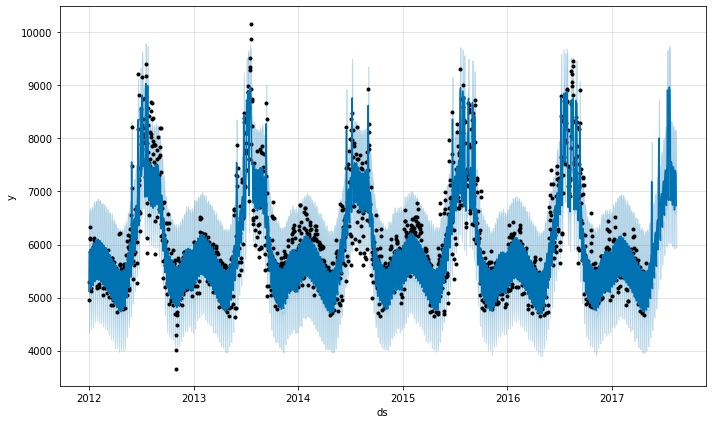

In [36]:
fig1 = m.plot(forecast)

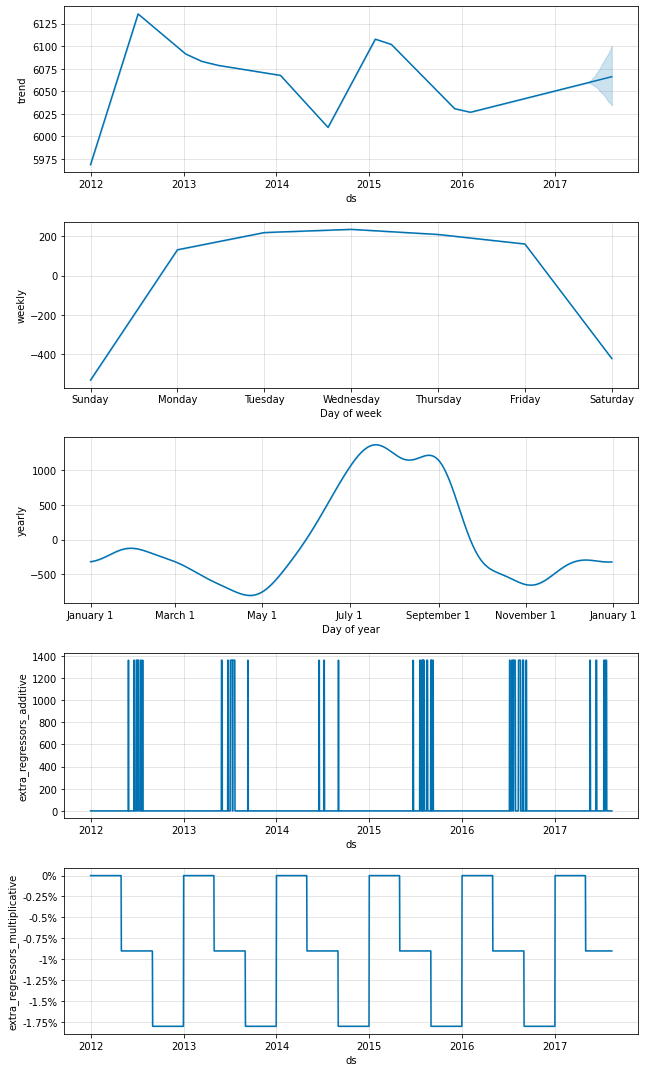

In [37]:
fig2 = m.plot_components(forecast)

In [38]:
from fbprophet.diagnostics import cross_validation,  performance_metrics
cv_results = cross_validation( model = m, initial = '731 days', horizon = '365 days')
df_p = performance_metrics(cv_results)
df_p

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,202285.749279,449.761881,351.118788,0.062256,0.052819,0.901099
1,37 days 00:00:00,208316.919927,456.417484,357.957015,0.063409,0.053519,0.895604
2,37 days 12:00:00,209634.750904,457.858877,360.400469,0.063821,0.054313,0.895604
3,38 days 00:00:00,213749.756327,462.330787,364.592561,0.064257,0.054982,0.890110
4,38 days 12:00:00,216038.669577,464.799602,368.572735,0.064891,0.055522,0.890110
...,...,...,...,...,...,...,...
653,363 days 00:00:00,150705.855446,388.208521,325.292187,0.059521,0.058536,0.978022
654,363 days 12:00:00,151355.393213,389.044205,325.529662,0.059562,0.058536,0.978022
655,364 days 00:00:00,154184.849927,392.663787,327.942953,0.060207,0.058950,0.972527
656,364 days 12:00:00,153824.079024,392.204129,326.976109,0.060049,0.058710,0.972527


Previous MAPE - 0.06 to 0.08

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



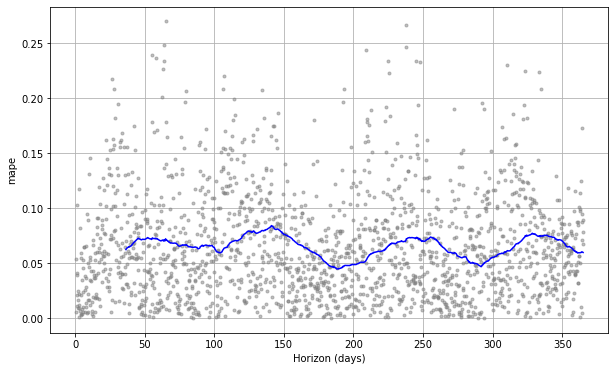

In [39]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric='mape')